In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, auc
import json
from tqdm import tqdm


In [2]:
fdir_raw = Path("../data/raw/")
fdir_processed = Path("../data/interim")
fdir_traintest = Path("../data/processed") / 'sex'
fdir_external = Path("../data/external")
ml_models_fdir = Path("../models")

use_CV = True

model_type = 'catboost'
model_type = 'xgboost'


#! SHOLD BE THE SAME AS IN train_model.py
# feature_importance_method = 'native'
feature_importance_method = 'SHAP'

# sex = 'chrXY'
# sex = 'chrX'
# sex = 'chrY'
# sex = 'autosome'

value_to_predict = 'Sex'

organ = "HEART"
sex= 'autosome'


In [3]:

with open(f'../models/{model_type}.json', 'r') as file:
    model_params = json.load(file)

if model_type == 'xgboost':
    model = xgb.XGBClassifier(**model_params)

fname = next((fdir_external / organ / 'reg').glob("*processed.h5"))
fname = fname.name

data_eval = pd.read_hdf(fdir_external / organ / 'reg' / fname, index_col=0)
data_eval_header = pd.read_csv(fdir_external / organ / 'reg' / 'SraRunTable.txt', sep=',')


features_fname = f"geuvadis_train_features_{sex}_calibration_{organ}.csv"
features_list = pd.read_csv(ml_models_fdir / model_type / features_fname, index_col=0)

data_eval = data_eval[features_list.index]


In [4]:
X = data_eval.values
X = RobustScaler().fit_transform(X)

y = data_eval_header['sex'].values
label_encoder = LabelEncoder().fit(y)
y = label_encoder.transform(y)

# y = (dataset['cardiac_chamber'].str.find('atrium') > 0).astype(int).values

predicted:    [0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0]
--------------------
mean_auc=0.3828282828282828,
mean_accuracy=0.5,
mean_f1=0.3555555555555555,
mean_precision=0.4222222222222222,
mean_recall=0.31111111111111106,
--------------------
```


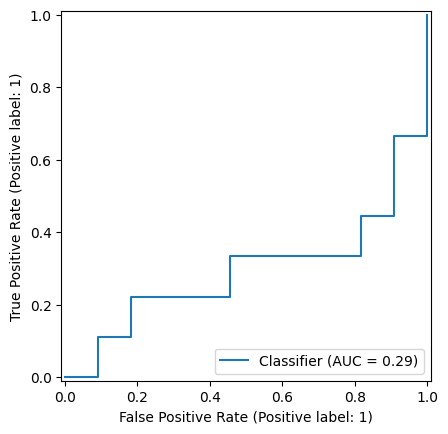

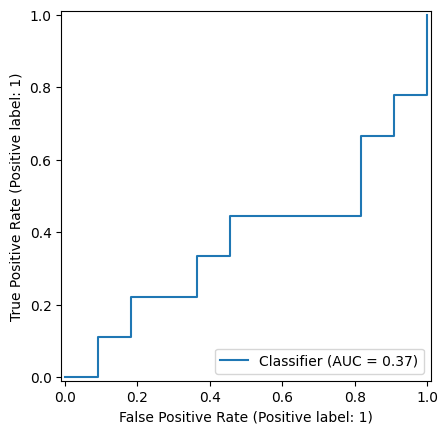

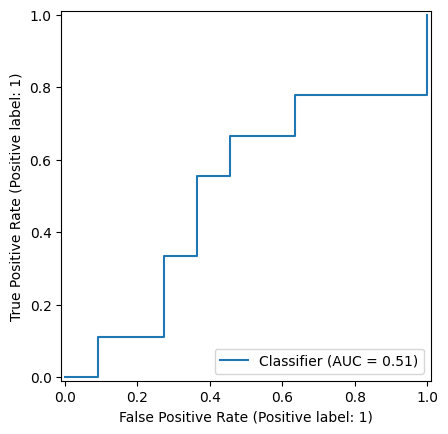

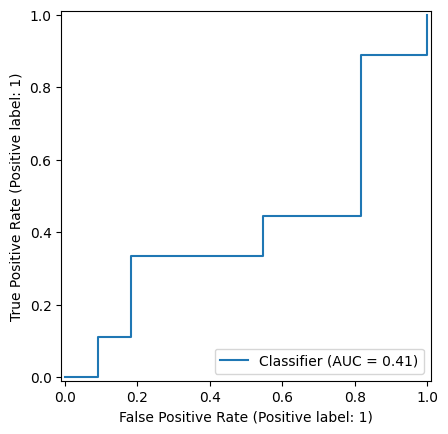

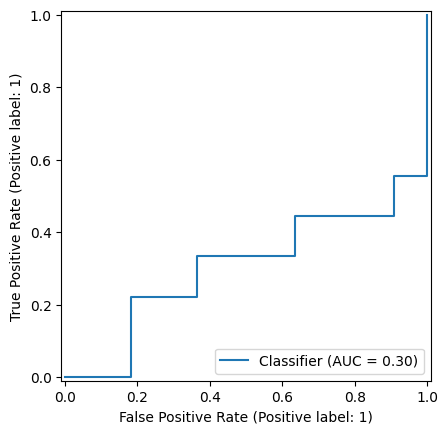

In [5]:
proba = np.zeros(shape=(X.shape[0], 2))
pred = np.zeros(shape=(X.shape[0]))

mean_fpr = np.linspace(0, 1, 100)
tprs = []
accuracies = []
f1 = []
precisions = []
recalls = []

for i in range(5):
    saved_model_filename = f"geuvadis_fold{i}_{sex}_calibration_{organ}.json"
    model.load_model(fname=ml_models_fdir / model_type / saved_model_filename)

    proba += model.predict_proba(X)
    pred_ = model.predict(X)
    # if sex == 'autosome':
    #     pred_ = np.abs(pred_ - 1)
    pred += pred_

    accuracies.append(accuracy_score(y, pred_))
    f1.append(f1_score(y, pred_))
    precisions.append(precision_score(y, pred_))
    recalls.append(recall_score(y, pred_))

    viz = RocCurveDisplay.from_predictions(
        y, model.predict_proba(X)[:, 1],
        # ax=ax,
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0
    tprs.append(interp_tpr)

proba = proba / 5
# pred = pred / 5
print('predicted:   ', (proba[:, 1] > 0.5).astype(int))
# print(pred.astype(int))

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0

mean_auc = auc(mean_fpr, mean_tpr)
mean_accuracy = np.mean(accuracies)
mean_f1 = np.mean(f1)
mean_precision = np.mean(precisions)
mean_recall = np.mean(recalls)

print("-" * 20)
print(f"{mean_auc=},")
print(f"{mean_accuracy=},")
print(f"{mean_f1=},")
print(f"{mean_precision=},")
print(f"{mean_recall=},")
print("-" * 20)
print('```')

In [6]:
proba[:, 1]

array([0.27220809, 0.13716225, 0.23862787, 0.59021615, 0.53947833,
       0.31351734, 0.81949002, 0.18318942, 0.18252071, 0.92370017,
       0.1866321 , 0.1826291 , 0.05446743, 0.01075386, 0.10581322,
       0.84451603, 0.65481769, 0.39736112, 0.10425968, 0.49408552])

In [7]:
# data_eval_header
test_header = data_eval_header.copy(deep=True)
# test_header['test_prediction'] = (proba[:, 1] > 0.5).astype(int)
test_header['sex_prediction'] = pred/5
test_header['sex_proba'] = proba[:, 1]

test_header['sex']

0     female
1     female
2     female
3     female
4     female
5     female
6     female
7     female
8     female
9     female
10    female
11      male
12      male
13      male
14      male
15      male
16      male
17      male
18      male
19      male
Name: sex, dtype: object

In [8]:
dataset = test_header[['cardiac_chamber', 'sex_prediction', 'sex_proba', 'sex']]
dataset

,cardiac_chamber,sex_prediction,sex_proba,sex
0,Right ventricle,0.0,0.272208,female
1,Left ventricle,0.0,0.137162,female
2,Right atrium,0.2,0.238628,female
3,Left atrium,0.8,0.590216,female
4,Right atrium,0.6,0.539478,female
5,Right ventricle,0.2,0.313517,female
6,Left atrium,1.0,0.819490,female
7,Right ventricle,0.0,0.183189,female
8,Left ventricle,0.0,0.182521,female
9,Right atrium,1.0,0.923700,female


In [9]:
(dataset['cardiac_chamber'].str.find('atrium') > 0).astype(int).values


array([0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1])

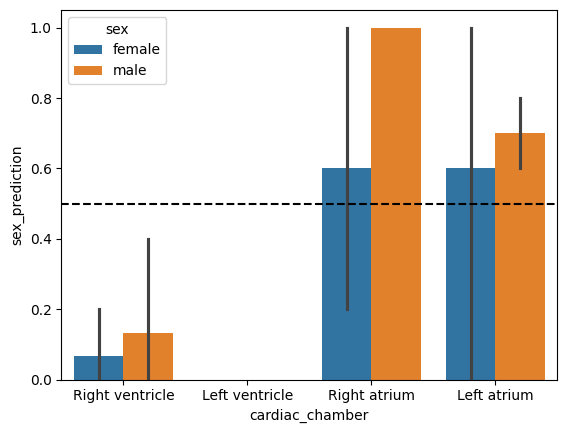

In [10]:
g = sns.barplot(dataset, x='cardiac_chamber', y='sex_prediction', hue='sex')
g.axhline(0.5, color='black', linestyle='dashed')
# plt.hlines(0.5, 0, 1)